# Faster Polynomial Features

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Polynomial Features

The current implementation of [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) (0.20.2) implements a term by term product for each pair $X_i, X_j$ of features where $i \leqslant j$ which is not the most efficient way to do it.

In [3]:
import numpy.random
X = numpy.random.random((100, 5))

In [4]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
Xpoly = poly.fit_transform(X)
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2']

In [5]:
%timeit poly.transform(X)

217 µs ± 24.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The class [ExtendedFeatures](http://www.xavierdupre.fr/app/mlinsights/helpsphinx/mlinsights/mlmodel/extended_features.html) implements a different way to compute the polynomial features as it tries to reduce the number of calls to numpy by using broacasted vector multplications.

In [6]:
from mlinsights.mlmodel import ExtendedFeatures
ext = ExtendedFeatures(poly_degree=2)
Xpoly = ext.fit_transform(X)
ext.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2']

In [7]:
%timeit ext.transform(X)

65.4 µs ± 3.14 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Comparison with 5 features

In [8]:
from cpyquickhelper.numbers import measure_time

In [9]:
res = []
for n in [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]:
    X = numpy.random.random((n, 5))
    r1 = measure_time("poly.fit_transform(X)", context=dict(X=X, poly=poly), repeat=2, number=30)
    r2 = measure_time("ext.fit_transform(X)", context=dict(X=X, ext=ext), repeat=2, number=30)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r1["size"] = n
    r2["size"] = n
    res.append(r1)
    res.append(r2)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,context_size,deviation,max_exec,min_exec,name,number,repeat,size
23,0.531702,240,0.008134,0.539836,0.523568,ext,30,2,50000
24,1.957072,240,0.164537,2.121609,1.792535,poly,30,2,100000
25,1.510021,240,0.108231,1.618252,1.401790,ext,30,2,100000
26,5.337007,240,0.621127,5.958134,4.715881,poly,30,2,200000
27,2.495960,240,0.059928,2.555888,2.436033,ext,30,2,200000


In [10]:
piv = df.pivot("size", "name", "average")
piv[:5]

name,ext,poly
size,,
10,0.003982,0.009674
20,0.003985,0.006776
50,0.004228,0.007938
100,0.004426,0.006901
200,0.004752,0.007631


Text(0.5, 0, 'number of observations')

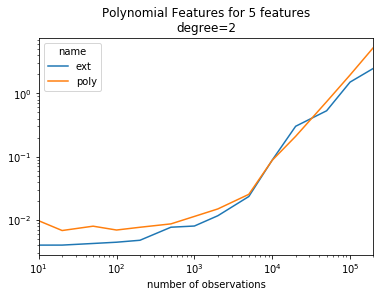

In [11]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 5 features\ndegree=2")
ax.set_xlabel("number of observations")

The gain is mostly visible for small dimensions.

## Comparison with 1000 observations

In this experiment, the number of observations is fixed to 1000 but the number of features varies.

In [12]:
res = []
for n in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 40, 50]:
    X = numpy.random.random((1000, n))
    r1 = measure_time("poly.fit_transform(X)", context=dict(X=X, poly=poly), repeat=5, number=30)
    r2 = measure_time("ext.fit_transform(X)", context=dict(X=X, ext=ext), repeat=5, number=30)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r1["nfeat"] = n
    r2["nfeat"] = n
    x1 = poly.transform(X)
    x2 = ext.transform(X)
    r1["numf"] = x1.shape[1]
    r2["numf"] = x2.shape[1]
    res.append(r1)
    res.append(r2)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,context_size,deviation,max_exec,min_exec,name,nfeat,number,numf,repeat
21,0.078633,240,0.001109,0.080767,0.077703,ext,20,30,231,5
22,0.656693,240,0.052091,0.741282,0.600194,poly,40,30,861,5
23,0.320291,240,0.054971,0.402318,0.270136,ext,40,30,861,5
24,0.985071,240,0.042695,1.056921,0.929831,poly,50,30,1326,5
25,0.419886,240,0.007862,0.431491,0.412107,ext,50,30,1326,5


In [13]:
piv = df.pivot("nfeat", "name", "average")
piv[:5]

name,ext,poly
nfeat,,
2,0.004479,0.006102
3,0.005374,0.006643
4,0.011120,0.008674
5,0.010467,0.014773
6,0.011214,0.016628


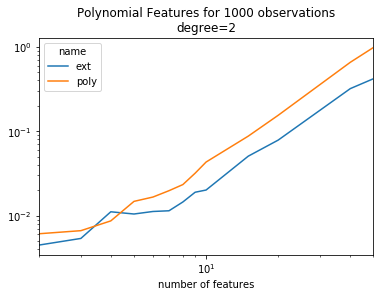

In [14]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 1000 observations\ndegree=2")
ax.set_xlabel("number of features");

It is faster by a short amount of time.

## Comparison for different degrees

In this experiment, the number of observations and features is fixed, the degree increases. Since dense matrix is usually organized by rows in memory, I was curious to know if there would be an even better gain by computing the polynomial features on the transposed matrix.

In [15]:
res = []
for n in [2, 3, 4, 5, 6, 7, 8]:
    X = numpy.random.random((1000, 4))
    poly = PolynomialFeatures(degree=n)
    ext = ExtendedFeatures(poly_degree=n)
    exttr = ExtendedFeatures(poly_degree=n, poly_transpose=True)
    poly.fit(X)
    ext.fit(X)
    exttr.fit(X)
    r1 = measure_time("poly.fit_transform(X)", context=dict(X=X, poly=poly), repeat=5, number=30)
    r2 = measure_time("ext.fit_transform(X)", context=dict(X=X, ext=ext), repeat=5, number=30)
    r3 = measure_time("exttr.fit_transform(X)", context=dict(X=X, exttr=exttr), repeat=5, number=30)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r3["name"] = "exttr"
    r1["degree"] = n
    r2["degree"] = n
    r3["degree"] = n
    x1 = poly.transform(X)
    x2 = ext.transform(X)
    x3 = exttr.transform(X)
    r1["numf"] = x1.shape[1]
    r2["numf"] = x2.shape[1]
    r3["numf"] = x3.shape[1]
    res.append(r1)
    res.append(r2)
    res.append(r3)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,context_size,degree,deviation,max_exec,min_exec,name,number,numf,repeat
16,0.125852,240,7,0.006171,0.138144,0.121958,ext,30,330,5
17,0.110981,240,7,0.002182,0.113280,0.107723,exttr,30,330,5
18,0.464963,240,8,0.086083,0.627122,0.379214,poly,30,495,5
19,0.188138,240,8,0.004002,0.192920,0.182541,ext,30,495,5
20,0.157409,240,8,0.000590,0.158048,0.156353,exttr,30,495,5


In [16]:
piv = df.pivot("degree", "name", "average")
piv[:5]

name,ext,exttr,poly
degree,,,
2,0.007025,0.004274,0.012518
3,0.012687,0.007023,0.019398
4,0.020881,0.012208,0.039225
5,0.033648,0.020769,0.068091
6,0.087181,0.065974,0.152152


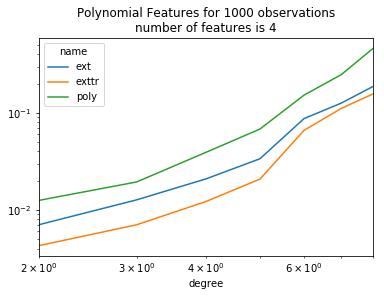

In [17]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 1000 observations\nnumber of features is 4")
ax.set_xlabel("degree");

It is worth transposing.